In [99]:
import pandas as pd
import numpy as np
import requests
import zipfile
import json
import matplotlib.pyplot as plt

from io import BytesIO

#### Bank of England yield curve data

This is available via download of a number of zip files in the following place:
https://www.bankofengland.co.uk/statistics/yield-curves

In [100]:
# Download ECB yield curve data
### Unfortunately this doesn't work - this seems to be due to how the BoE implement their yield curve data downloads

yield_curve_url = 'https://www.bankofengland.co.uk/-/media/boe/files/statistics/yield-curves/glcnominalddata.zip'
response = requests.get(yield_curve_url)

# Extract dataframes from zip file
import zipfile
zip_file = zipfile.ZipFile(BytesIO(response.content))
zip_file.extractall()

BadZipFile: File is not a zip file

In [111]:
# Open zipfile from location and extract data

fwds_raw = []
spot_raw = []

zip_path = 'D:\\Users\\bened\\Downloads\\glcnominalddata.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Step 2: List all contained files to find the CSV
    file_names = zip_ref.namelist()
    # Assuming the first file is the CSV you want to extract
    for csv_file_name in file_names:
    
        # Step 3: Open the CSV file within the zip
        with zip_ref.open(csv_file_name) as csv_file:
            # Step 4: Read the CSV into a DataFrame
            try:
                fwds_raw += [pd.read_excel(csv_file, sheet_name='2. nominal fwd curve', skiprows=3, parse_dates=['years:'])]
            except:
                fwds_raw += [pd.read_excel(csv_file, sheet_name='2. fwd curve', skiprows=3, parse_dates=['years:'])]
            try:
                spot_raw += [pd.read_excel(csv_file, sheet_name='4. nominal spot curve', skiprows=3, parse_dates=['years:'])]
            except:
                spot_raw += [pd.read_excel(csv_file, sheet_name='4. spot curve', skiprows=3, parse_dates=['years:'])]

In [112]:
# Calculate unique values in the dataset
fwd_rate = pd.concat([fwd_raw.dropna(subset=['years:']).set_index('years:', drop=True) for fwd_raw in fwds_raw]
                    ).sort_index(axis=1).sort_index(axis=0).copy()

spot_rate = pd.concat([spot_raw.dropna(subset=['years:']).set_index('years:', drop=True) for spot_raw in spot_raw]
                    ).sort_index(axis=1).sort_index(axis=0).copy()

# Get maximum date
curve_date = np.max(spot_rate.index)

In [ ]:
# Generate a dictionary of tenor lengths
tenor_dict = {x: x for x in fwd_rate.columns}

# Tenor dict subset
tenor_dict_subset = tenor_dict.copy()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, sharey=True, sharex=True, figsize=(12,5))

# Plot par yields with swap rates
spot_rate.loc[curve_date].plot.line(ax=ax1, label='SPOT', color='r')

# Plot forward rates
fwd_rate.loc[curve_date].plot.line(ax=ax2, label='FWD', color='g')

# Set ax1 range
ax1.set_xlim(0)
ax1.axhline(0, color='black')
ax2.axhline(0, color='black')

In [119]:
pd.set_option('future.no_silent_downcasting', True)

for col in fwd_rate.columns:
    fwd_rate[col] = np.where(np.all([
        fwd_rate[col]==fwd_rate[col].shift(1),
        fwd_rate[col]==fwd_rate[col].shift(2),
        fwd_rate[col]==fwd_rate[col].shift(3),
        fwd_rate[col]==fwd_rate[col].shift(4),
        fwd_rate[col]==fwd_rate[col].shift(5)
    ]), None, fwd_rate[col])
    fwd_rate[col] = fwd_rate[col].ffill(limit=3)
    
for col in spot_rate.columns:
    spot_rate[col] = np.where(np.all([
        spot_rate[col]==spot_rate[col].shift(1),
        spot_rate[col]==spot_rate[col].shift(2),
        spot_rate[col]==spot_rate[col].shift(3),
        spot_rate[col]==spot_rate[col].shift(4),
        spot_rate[col]==spot_rate[col].shift(5)
    ]), None, spot_rate[col])
    spot_rate[col] = spot_rate[col].ffill(limit=3)

In [140]:
spot_rate.loc[f'{start_year}-01-01':].sort_values(25).head()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,35.5,36.0,36.5,37.0,37.5,38.0,38.5,39.0,39.5,40.0
years:,,,,,,,,,,,,,,,,,,,,,
2020-03-09,0.22387,0.170612,0.133142,0.111051,0.097199,0.087449,0.079983,0.074173,0.069953,0.067486,...,0.453553,0.447317,0.441341,0.43565,0.430265,0.425204,0.420479,0.416101,0.412074,0.408401
2020-03-10,0.272253,0.213141,0.176399,0.155817,0.143201,0.134396,0.127697,0.122575,0.119035,0.117278,...,0.461524,0.454116,0.447016,0.440256,0.433864,0.42786,0.422263,0.417084,0.41233,0.408004
2020-05-05,0.038724,0.042474,0.035243,0.030324,0.027992,0.027024,0.027091,0.028416,0.031332,0.036174,...,0.453514,0.445464,0.437674,0.430171,0.422979,0.416116,0.4096,0.403438,0.397636,0.392194
2020-05-08,0.048043,0.043946,0.03062,0.022806,0.020388,0.021362,0.024751,0.030277,0.037899,0.047662,...,0.468188,0.460935,0.453928,0.447186,0.44073,0.434573,0.428729,0.423204,0.418001,0.413119
2020-05-07,0.048043,0.043946,0.03062,0.022806,0.020388,0.021362,0.024751,0.030277,0.037899,0.047662,...,0.468188,0.460935,0.453928,0.447186,0.44073,0.434573,0.428729,0.423204,0.418001,0.413119


In [136]:
spot_rate.loc[f'{start_year}-01-01':].corr()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,35.5,36.0,36.5,37.0,37.5,38.0,38.5,39.0,39.5,40.0
0.5,1.000000,0.997447,0.992134,0.985296,0.977624,0.969502,0.961093,0.952445,0.943563,0.934445,...,0.957740,0.958006,0.958255,0.958484,0.958693,0.958881,0.959045,0.959185,0.959300,0.959388
1.0,0.997447,1.000000,0.998303,0.994070,0.988296,0.981582,0.974236,0.966411,0.958187,0.949618,...,0.944586,0.944871,0.945135,0.945376,0.945592,0.945782,0.945943,0.946074,0.946173,0.946238
1.5,0.992134,0.998303,1.000000,0.998637,0.995182,0.990345,0.984543,0.978008,0.970880,0.963254,...,0.943636,0.943886,0.944117,0.944327,0.944514,0.944676,0.944811,0.944918,0.944994,0.945039
2.0,0.985296,0.994070,0.998637,1.000000,0.998918,0.996114,0.992065,0.987058,0.981276,0.974850,...,0.944745,0.944963,0.945165,0.945346,0.945507,0.945644,0.945756,0.945842,0.945900,0.945928
2.5,0.977624,0.988296,0.995182,0.998918,1.000000,0.999121,0.996780,0.993303,0.988901,0.983728,...,0.947300,0.947488,0.947661,0.947816,0.947952,0.948066,0.948158,0.948225,0.948266,0.948280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38.0,0.958881,0.945782,0.944676,0.945644,0.948066,0.951303,0.954916,0.958629,0.962276,0.965749,...,0.999952,0.999971,0.999984,0.999993,0.999998,1.000000,0.999999,0.999995,0.999988,0.999980
38.5,0.959045,0.945943,0.944811,0.945756,0.948158,0.951376,0.954970,0.958666,0.962297,0.965755,...,0.999934,0.999956,0.999973,0.999986,0.999994,0.999999,1.000000,0.999999,0.999995,0.999989
39.0,0.959185,0.946074,0.944918,0.945842,0.948225,0.951426,0.955004,0.958685,0.962301,0.965747,...,0.999915,0.999941,0.999961,0.999976,0.999987,0.999995,0.999999,1.000000,0.999999,0.999995
39.5,0.959300,0.946173,0.944994,0.945900,0.948266,0.951452,0.955016,0.958685,0.962289,0.965723,...,0.999895,0.999923,0.999946,0.999964,0.999978,0.999988,0.999995,0.999999,1.000000,0.999999


<Axes: xlabel='0.5', ylabel='11.0'>

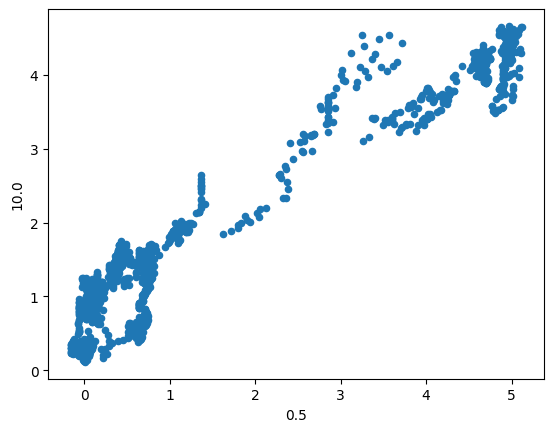

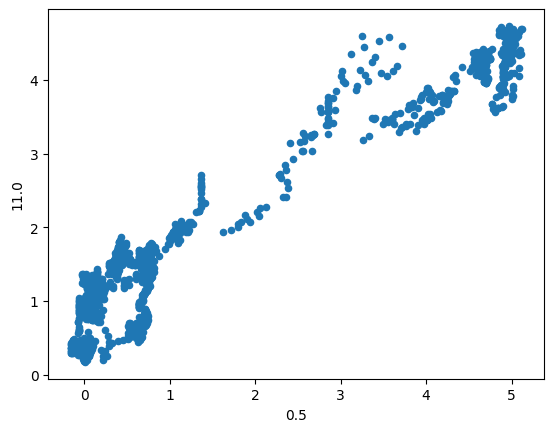

In [144]:
spot_rate.loc[f'{start_year}-01-01':].dropna().plot.scatter(x=0.5, y=19)
spot_rate.loc[f'{start_year}-01-01':].dropna().plot.scatter(x=0.5, y=21)

<Axes: title={'center': 'Forward Rate Correlation'}>

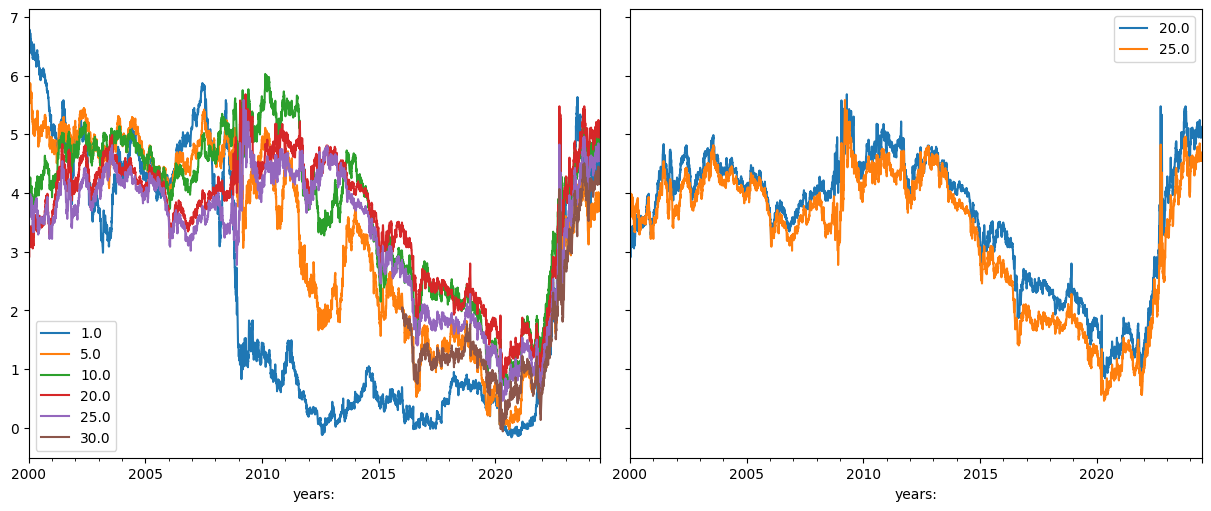

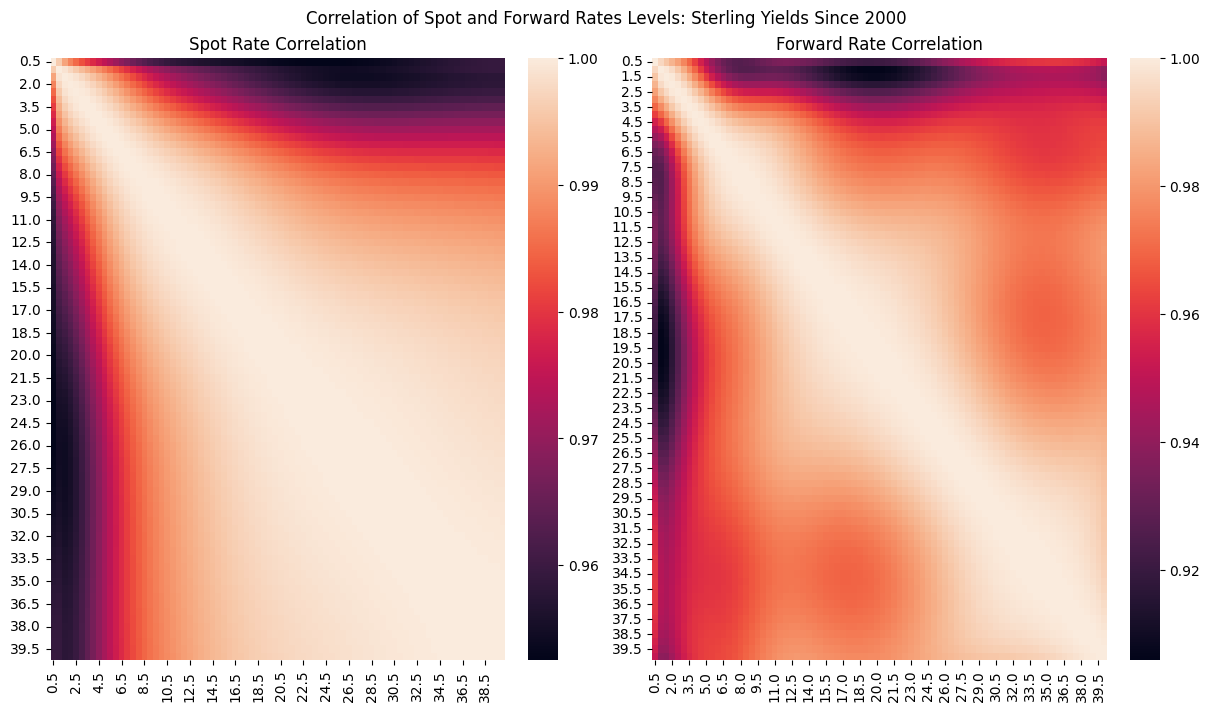

In [146]:
start_year = 2000

fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, sharey=True, sharex=True, figsize=(12,5))
fwd_rate.loc[f'{start_year}-01-01':, [1, 5,10,20,25,30]].plot(ax=ax1)
fwd_rate.loc[f'{start_year}-01-01':, [20,25]].plot(ax=ax2)

fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, figsize=(12,7))
from seaborn import heatmap
plt.suptitle(f'Correlation of Spot and Forward Rates Levels: Sterling Yields Since {start_year}')
ax1.set_title('Spot Rate Correlation')
heatmap(spot_rate.loc[f'{start_year}-01-01':].dropna().corr(), ax=ax1)#, title='Spot Rate Correlation')
ax2.set_title('Forward Rate Correlation')
heatmap(fwd_rate.loc[f'{start_year}-01-01':].dropna().corr(), ax=ax2)#, title='FWD Rate Correlation')

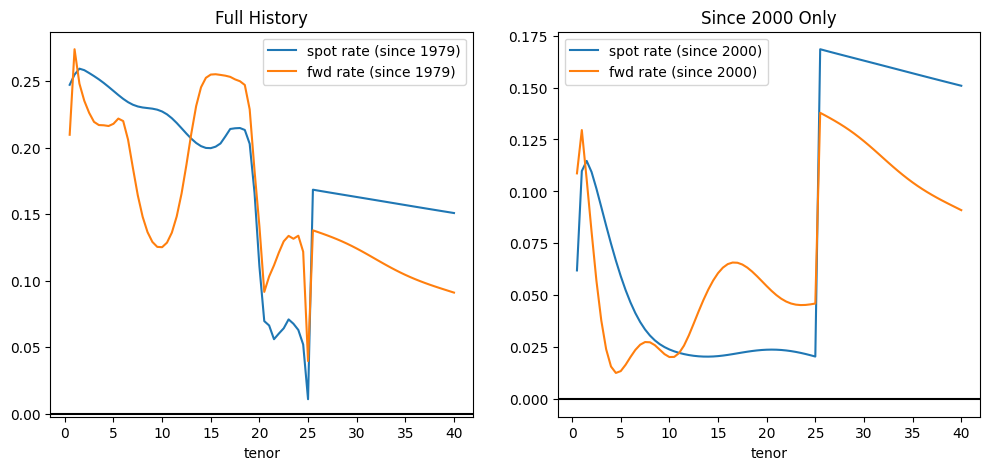

In [149]:
period_length = 5
start_year = 2000

# Calculate curve changes
fwd_rate_change = - fwd_rate.diff(periods=-period_length)
spot_rate_change = - spot_rate.diff(periods=-period_length)

# Regress squared level changes against level
rate_vol_regression = pd.DataFrame({'tenor':tenor_dict})
#rate_vol_regression[f'spot rate (since {str(np.min(spot_rate_change.index))[:4]})'] = None
#rate_vol_regression[f'spot rate (since {1990})'] = None
#rate_vol_regression['corr: fwd rate vol to level'] = None

for tenor in rate_vol_regression.index:
    try:
        spot_rate_delta = pd.DataFrame({'level':spot_rate[tenor], 'change': spot_rate_change[tenor], 'change_sq': spot_rate_change[tenor] ** 2}
                                       ).dropna().copy()
        rate_vol_regression.loc[tenor, f'spot rate (since {str(np.min(spot_rate_change.index))[:4]})'
        ] = (spot_rate_delta.change_sq).corr(spot_rate_delta.level)
        rate_vol_regression.loc[tenor, f'spot rate (since {start_year})'] = (
                spot_rate_delta.loc[f'{start_year}-01-01':, 'change_sq']).corr(spot_rate_delta.loc[f'{start_year}-01-01':, 'level'])
    except:
        pass
    try:
        fwd_rate_delta = pd.DataFrame({'level':fwd_rate[tenor], 'change': fwd_rate_change[tenor], 'change_sq': fwd_rate_change[tenor] ** 2}
                                      ).dropna().copy()
        rate_vol_regression.loc[tenor, f'fwd rate (since {str(np.min(fwd_rate_change.index))[:4]})'
        ] = (fwd_rate_delta.change_sq).corr(fwd_rate_delta.level)
        rate_vol_regression.loc[tenor, f'fwd rate (since {start_year})'] = (
                fwd_rate_delta.loc[f'{start_year}-01-01':, 'change_sq']).corr(fwd_rate_delta.loc[f'{start_year}-01-01':, 'level'])
    except:
        pass
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
rate_vol_regression.sort_values('tenor').plot(x='tenor', y=[x for x in rate_vol_regression.columns if f'{start_year}' not in x and x!= 'tenor'], 
                                              title='Full History', ax=ax1)
rate_vol_regression.sort_values('tenor').plot(x='tenor', y=[x for x in rate_vol_regression.columns if f'{start_year}' in x], title=f'Since {start_year} Only', ax=ax2)
ax1.axhline(0, color='black')
ax2.axhline(0, color='black')

[]

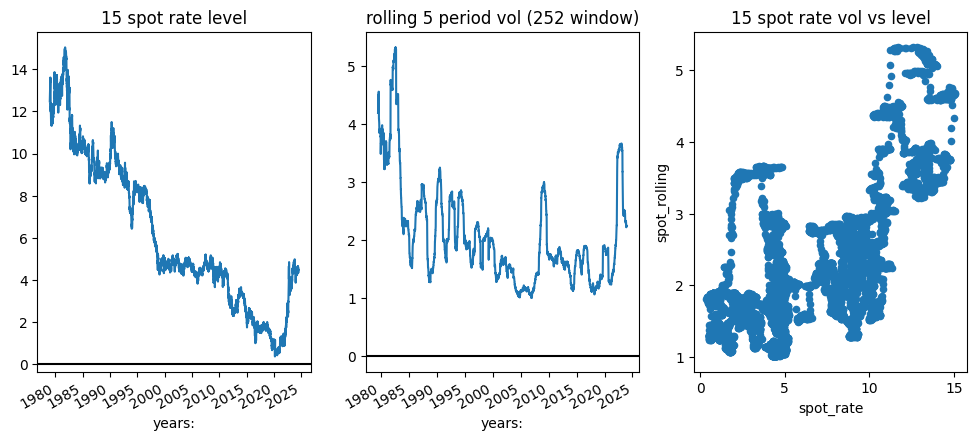

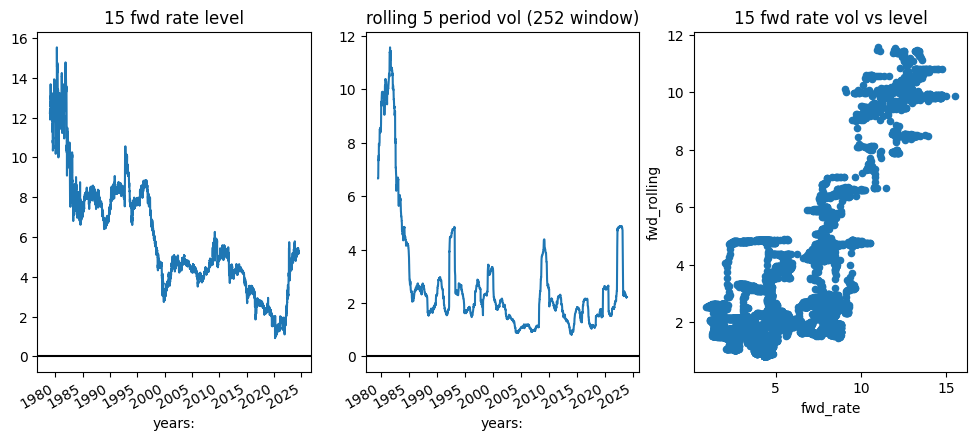

In [74]:
tenor = 15
period_length = 5
rolling_length = 252

single_tenor_ts = pd.DataFrame({'spot_rate': spot_rate[tenor], 'fwd_rate': fwd_rate[tenor]}).dropna()
single_tenor_ts.rename({f'IF_{tenor}': 'fwd_rate', f'SR_{tenor}':'spot_rate'}, axis=1, inplace=True)
single_tenor_ts['fwd_change'] = - single_tenor_ts.fwd_rate.diff(periods=-period_length)
single_tenor_ts['fwd_vol'] = single_tenor_ts.fwd_change**2
single_tenor_ts['fwd_rolling'] = single_tenor_ts.fwd_change.rolling(rolling_length).std().shift(int(-rolling_length/2)) * 252 ** 0.5

single_tenor_ts['spot_change'] = - single_tenor_ts.spot_rate.diff(periods=-period_length)
single_tenor_ts['spot_vol'] = single_tenor_ts.spot_change**2
single_tenor_ts['spot_rolling'] = single_tenor_ts.spot_change.rolling(rolling_length).std().shift(int(-rolling_length/2)) * 252 ** 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
single_tenor_ts.spot_rate.plot(ax=ax1, title=f'{tenor} spot rate level')
ax1.axhline(0, color='black')
single_tenor_ts.spot_rolling.plot(ax=ax2, title=f'rolling {period_length} period vol ({rolling_length} window)')
ax2.axhline(0, color='black')
single_tenor_ts.plot.scatter('spot_rate', 'spot_rolling', ax=ax3, title=f'{tenor} spot rate vol vs level')
plt.plot()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
single_tenor_ts.fwd_rate.plot(ax=ax1, title=f'{tenor} fwd rate level')
ax1.axhline(0, color='black')
single_tenor_ts.fwd_rolling.plot(ax=ax2, title=f'rolling {period_length} period vol ({rolling_length} window)')
ax2.axhline(0, color='black')
single_tenor_ts.plot.scatter('fwd_rate', 'fwd_rolling', ax=ax3, title=f'{tenor} fwd rate vol vs level')
plt.plot()